In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.io import loadmat, savemat
import math

torch.set_default_dtype(torch.float32)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# MERL functions
def rotate_vector(vec, axis, angle):

    axis = np.array(axis, dtype=float)
    axis = axis / np.linalg.norm(axis)  
    vec = np.array(vec, dtype=float)

    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)


    rotated_vec = (
        cos_theta * vec +
        sin_theta * np.cross(axis, vec) +
        (1 - cos_theta) * np.dot(axis, vec) * axis
    )
    return rotated_vec

def conv_half_diff_to_std(thetaH, phiH, thetaD, phiD):

    H = np.array([
        np.sin(thetaH) * np.cos(phiH),
        np.sin(thetaH) * np.sin(phiH),
        np.cos(thetaH)
    ])
    D = np.array([
        np.sin(thetaD) * np.cos(phiD),
        np.sin(thetaD) * np.sin(phiD),
        np.cos(thetaD)
    ])

    H /= np.linalg.norm(H)
    D /= np.linalg.norm(D)

    wi = rotate_vector(rotate_vector(D, [0, 1, 0], thetaH), [0, 0, 1], phiH)
    wi /= np.linalg.norm(wi)

    wo = 2 * np.dot(wi, H) * H - wi
    wo /= np.linalg.norm(wo)

    thetaI = np.arccos(wi[2])
    phiI = np.arctan2(wi[1], wi[0])

    thetaO = np.arccos(wo[2])
    phiO = np.arctan2(wo[1], wo[0])

    if np.degrees(thetaI) > 90 or np.degrees(thetaO) > 90:
        return np.nan, np.nan, np.nan, np.nan

    return thetaI, phiI, thetaO, phiO


# Function to split sample names into training and validation sets based on group names (to avoid data leakage)
def group_based_split(sample_names, tv_pct=0.8, random_seed=42):
    import torch
    from collections import defaultdict
    import re

    def extract_group(name):
        """
        Extracts base material/group name from the sample filename.
        Assumes format like 'acrylic_felt_orange_rgb_1...9'
        """
        # Remove extension if any
        name = name.split('.')[0]

        parts = name.split('_')

        # Keep only the first 3 parts as base group (adjust if needed)
        base_group = '_'.join(parts[:3])
        return base_group

    # Group indices by material group
    group_to_indices = defaultdict(list)
    for idx, name in enumerate(sample_names):
        group_name = extract_group(name)
        group_to_indices[group_name].append(idx)

    # Shuffle group order reproducibly
    all_groups = list(group_to_indices.keys())
    torch.manual_seed(random_seed)
    shuffled_indices = torch.randperm(len(all_groups)).tolist()
    shuffled_groups = [all_groups[i] for i in shuffled_indices]

    # Split group names into train/val sets
    n_groups = len(shuffled_groups)
    n_train_groups = round(n_groups * tv_pct)
    train_groups = set(shuffled_groups[:n_train_groups])
    val_groups   = set(shuffled_groups[n_train_groups:])

    # Map back to sample indices
    train_indices = []
    val_indices = []
    for group, idx_list in group_to_indices.items():
        if group in train_groups:
            train_indices.extend(idx_list)
        else:
            val_indices.extend(idx_list)

    train_indices.sort()
    val_indices.sort()

    return train_indices, val_indices


class CustomDataset(Dataset):
    def __init__(self, ref_data, model_data, labels):
        self.ref_data = ref_data
        self.model_data = model_data
        self.labels = labels
        self.num_brdfs = ref_data.size(2)

    def __len__(self):

        return self.num_brdfs

    def __getitem__(self, idx):
        #import pdb; pdb.set_trace()
        ref_sample = self.ref_data[:, :, idx]  # Shape: [features]
        model_sample = self.model_data[:, :, idx]  # Shape: [features]
        label = self.labels[idx]  # Label for (BRDF, model) pair

        return ref_sample, model_sample, label
    



In [ ]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        # He initialization for weights
        nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)  # Explicitly initialize biases to zero
    elif isinstance(module, (nn.BatchNorm1d, Net.SafeBatchNorm1d)):
        # Standard initialization for BatchNorm
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)



class Net(nn.Module):


    class SafeBatchNorm1d(nn.BatchNorm1d):
        def forward(self, input):
            if input.size(0) == 1:  # Single-sample batch
                return input  # Bypass BatchNorm
            return super(Net.SafeBatchNorm1d, self).forward(input)

    class MLP(nn.Module):
        def __init__(self, input_dim, num_classes, num_layers, neurons_per_layer, dropout_rate, min_normalized, max_normalized, decay_rate):
            super(Net.MLP, self).__init__()

            
            self.min_normalized = min_normalized
            self.max_normalized = max_normalized

            layers = []

            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.LayerNorm(neurons_per_layer)) 
            #layers.append(Net.SafeBatchNorm1d(neurons_per_layer))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))

            current_dim = neurons_per_layer
            for _ in range(num_layers - 1):
                next_dim = max(32, int(current_dim * decay_rate))
                layers.append(nn.Linear(current_dim, next_dim))
                layers.append(nn.LayerNorm(next_dim)) 
                #layers.append(Net.SafeBatchNorm1d(next_dim))
                layers.append(nn.GELU())
                layers.append(nn.Dropout(dropout_rate))
                current_dim = next_dim

            layers.append(nn.Linear(current_dim, num_classes))

            self.model = nn.Sequential(*layers)

            self.apply(self.kaiming_init)
            
        def kaiming_init(self, m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        def forward(self, x):
            
            x = self.model(x)
            x = torch.sigmoid(x) * (self.max_normalized - self.min_normalized) + self.min_normalized
            return x


In [ ]:
# Function to load labels from a CSV file
def load_labels(csv_file):

    with open(csv_file, newline='') as csvfile:
        rdr = csv.reader(csvfile, delimiter=',')
        classification_labels = []
        regression_labels = []
        names = []

        next(rdr)  # Skip the header
        for row in rdr:
            if row:
                names.append(row[0])
                regression_labels.append(float(row[4]))
                classification_labels.append(int(row[5]))
    
    return names, classification_labels, regression_labels

# Function to load BRDF data from .mat files
def load_data(brdf_directory, brdf_files, transform='cube-root'):
    brdf_data = None
    directions = None
    for brdf_file in brdf_files:
        refpath = os.path.join(brdf_directory, brdf_file)
        mat_data = loadmat(refpath)
        if 'r' in mat_data:
            r_sampled = mat_data['r']
        if 'g' in mat_data:
            g_sampled = mat_data['g']
        if 'b' in mat_data:
            b_sampled = mat_data['b']
        if 'random_locations' in mat_data:
            directions = mat_data['random_locations']
        for i in range(directions.shape[0]):
            theta_i, phi_i, theta_o, phi_o = conv_half_diff_to_std(
                math.radians(directions[i, 0]), 0, math.radians(directions[i, 1]), math.radians(directions[i, 2])
            )
            if transform == 'log-costi-plus':
                r_sampled[i] = np.log(np.maximum(np.nan_to_num(r_sampled[i] * np.cos(theta_i) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                g_sampled[i] = np.log(np.maximum(np.nan_to_num(g_sampled[i] * np.cos(theta_i) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                b_sampled[i] = np.log(np.maximum(np.nan_to_num(b_sampled[i] * np.cos(theta_i) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
            elif transform == 'log-costo-plus':
                r_sampled[i] = np.log(np.maximum(np.nan_to_num(r_sampled[i] * np.cos(theta_o) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                g_sampled[i] = np.log(np.maximum(np.nan_to_num(g_sampled[i] * np.cos(theta_o) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                b_sampled[i] = np.log(np.maximum(np.nan_to_num(b_sampled[i] * np.cos(theta_o) + 1, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
            elif transform == 'log-costi-costo-plus':
                r_sampled[i] = np.log(np.maximum(np.nan_to_num(r_sampled[i] * np.cos(theta_i) * np.cos(theta_o) + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                g_sampled[i] = np.log(np.maximum(np.nan_to_num(g_sampled[i] * np.cos(theta_i) * np.cos(theta_o) + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                b_sampled[i] = np.log(np.maximum(np.nan_to_num(b_sampled[i] * np.cos(theta_i) * np.cos(theta_o) + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
            elif transform == 'logplus':
                r_sampled[i] = np.log(np.maximum(np.nan_to_num(r_sampled[i] + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                g_sampled[i] = np.log(np.maximum(np.nan_to_num(g_sampled[i] + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                b_sampled[i] = np.log(np.maximum(np.nan_to_num(b_sampled[i] + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
            elif transform == 'logplus1':
                r_sampled[i] = np.log(r_sampled[i] + 1)
                g_sampled[i] = np.log(g_sampled[i] + 1)
                b_sampled[i] = np.log(b_sampled[i] + 1)
            elif transform == 'rgb2yuv':
                R = max(r_sampled[i], 0)
                G = max(g_sampled[i], 0)
                B = max(b_sampled[i], 0)
                
                Y = 0.299 * R + 0.587 * G + 0.114 * B
                U = -0.14713 * R - 0.28886 * G + 0.436 * B
                V = 0.615 * R - 0.51499 * G - 0.10001 * B

                Y = np.log(np.maximum(np.nan_to_num(Y + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                U = np.log(np.maximum(np.nan_to_num(U + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                V = np.log(np.maximum(np.nan_to_num(V + 1e-4, nan=1e-4, posinf=1e-4, neginf=1e-4), 1e-4))
                
                r_sampled[i] = Y
                g_sampled[i] = U
                b_sampled[i] = V

            elif transform == 'cube-root':
                r_sampled[i] = np.cbrt(r_sampled[i])
                g_sampled[i] = np.cbrt(g_sampled[i])
                b_sampled[i] = np.cbrt(b_sampled[i])

                r_sampled[i] = np.log(1 + r_sampled[i])
                g_sampled[i] = np.log(1 + g_sampled[i])
                b_sampled[i] = np.log(1 + b_sampled[i])


            elif transform == 'perc':
                a = 2.51
                b = 0.03
                c = 2.43

                r_sampled[i] = (a * r_sampled[i] + b) / (r_sampled[i] + c)
                g_sampled[i] = (a * g_sampled[i] + b) / (g_sampled[i] + c)
                b_sampled[i] = (a * b_sampled[i] + b) / (b_sampled[i] + c)
        

        rgb_t = torch.cat([torch.from_numpy(r_sampled), torch.from_numpy(g_sampled), torch.from_numpy(b_sampled)], dim=1)      # shape (N,3)

        data = rgb_t
        data.unsqueeze_(2)
        
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        if brdf_data is None:
            brdf_data = data
            #directions_data = directions
        else:
            brdf_data = torch.cat((brdf_data, data), dim=2)
    return brdf_data


In [5]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, classification):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    if classification:
        for ref, model_data, labels in train_loader:
            inputs = torch.cat((ref, model_data), dim=1).view(-1, input_dim).to(device).float()
            labels = labels.long().to(device) #long

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return train_loss / len(train_loader), accuracy
    else:
        for ref, model_data, labels in train_loader:
            inputs = torch.cat((ref, model_data), dim=1).view(-1, input_dim).to(device).float()
            labels = labels.float().to(device) #long
            labels = labels.view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().detach().numpy())

        return train_loss / len(train_loader), y_true, y_pred


def validate(model, val_loader, criterion, device, classification):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    if classification:

        with torch.no_grad():
            for ref, model_data, labels in val_loader:
                inputs = torch.cat((ref, model_data), dim=1).view(-1, input_dim).to(device).float()
                labels = labels.long().to(device) #long

                #import pdb; pdb.set_trace()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                #y_pred.extend(outputs.cpu().numpy())

        accuracy = 100 * correct / total
        return val_loss / len(val_loader), accuracy, y_true, y_pred
    else: 
        with torch.no_grad():
            for ref, model_data, labels in val_loader:
                inputs = torch.cat((ref, model_data), dim=1).view(-1, input_dim).to(device).float()
                labels = labels.float().to(device) #long
                labels = labels.view(-1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().detach().numpy())

        return val_loss / len(val_loader), y_true, y_pred 

In [6]:
main_directory = 'D:/Projects/Paper05/brdf-error/uniform_rand_500'
ref_directory = f'{main_directory}/ref'
model_directory = f'{main_directory}/model'

csv_file = 'labels_balanced_train.csv' #'labels_balanced_py_class=7.csv

names, classification_labels, regression_labels = load_labels(csv_file)
brdf_files = [name + '.mat' for name in names]#[:20]

ref_data = load_data(ref_directory, brdf_files)
model_data = load_data(model_directory, brdf_files)

In [ ]:
import time

classification = False
reg_labels = regression_labels

if classification:
    labels = classification_labels
    labels = torch.tensor(labels, dtype=torch.int)  
    num_classes = num_classes = int(torch.max(labels).item()) + 1
    
else:
    labels = reg_labels
    labels = torch.tensor(labels, dtype=torch.float32)
    num_classes = 1
reg_labels = torch.tensor(reg_labels, dtype=torch.float32)
ref_shape = ref_data.size()


train_indices, val_indices = group_based_split(names, tv_pct=0.8, random_seed=42)

ref_train_set = ref_data[:, :, train_indices]
ref_val_set = ref_data[:, :, val_indices]

model_train_set = model_data[:, :, train_indices]
model_val_set = model_data[:, :, val_indices]

train_labels = labels[train_indices]
val_labels = labels[val_indices]

# Create a second set of training data with a random scale factor
scale_factor = 0.95 + 0.1 * torch.rand_like(ref_train_set)  
ref_train_set_sc = ref_train_set * scale_factor
model_train_set_sc = model_train_set * scale_factor

ref_train_set = torch.cat((ref_train_set, ref_train_set_sc), dim=2)
model_train_set = torch.cat((model_train_set, model_train_set_sc), dim=2)
train_labels = torch.cat((train_labels, train_labels, train_labels), dim=0)

# Normalize the data
train_mean = torch.mean(ref_train_set)
train_std= torch.std(ref_train_set)

ref_train_set = (ref_train_set - train_mean) / train_std
ref_val_set = (ref_val_set - train_mean) / train_std
model_train_set = (model_train_set - train_mean) / train_std
model_val_set = (model_val_set - train_mean) / train_std

if classification:
    min_normalized = 0
    max_normalized = 1
    labels_mean = 0
    labels_std = 1
else:
    labels_mean = torch.mean(train_labels)
    labels_std = torch.std(train_labels)
    train_labels = (train_labels - labels_mean) / labels_std
    val_labels = (val_labels - labels_mean) / labels_std
    #test_labels = (test_labels - labels_mean) / labels_std
    min_normalized = torch.min(train_labels)
    max_normalized = torch.max(train_labels)

train_info = {
    "train_mean_rgb": train_mean,
    "train_std_rgb": train_std,
    "labels_mean": labels_mean,
    "labels_std": labels_std,
    "min_normalized": min_normalized,
    "max_normalized": max_normalized
}
#savemat('train_info.mat', train_info)

train_dataset = CustomDataset(ref_train_set, model_train_set, train_labels)
val_dataset = CustomDataset(ref_val_set, model_val_set, val_labels)

input_dim = ref_train_set.size(0) * ref_train_set.size(1) * 2  


MLP(
  (model): Sequential(
    (0): Linear(in_features=3000, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=716, bias=True)
    (5): LayerNorm((716,), eps=1e-05, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=716, out_features=501, bias=True)
    (9): LayerNorm((501,), eps=1e-05, elementwise_affine=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=501, out_features=1, bias=True)
  )
)
Epoch 0: Train Loss: 0.8029, Val Loss: 0.4417, Train RMSE: 3.3290, Val RMSE: 2.5778
Epoch 1: Train Loss: 0.5138, Val Loss: 0.2696, Train RMSE: 2.5766, Val RMSE: 1.5865
Epoch 2: Train Loss: 0.2976, Val Loss: 0.2265, Train RMSE: 1.7681, Val RMSE: 1.4057
Epoch 3: Train Loss: 0.2008, Val Loss: 0.1697, Train 

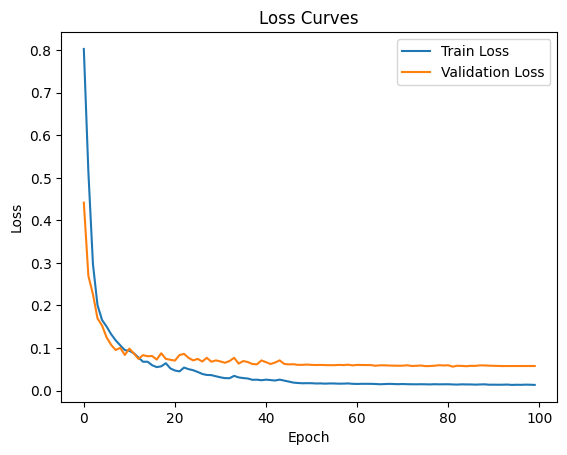

In [ ]:
best_val_accuracy = 0.0
best_val_rmse = float('inf')
best_config = None
results = [] 
test_y_true_all, test_y_pred_all = [], []

""" regression """
learning_rate = 1e-3
batch_size = 512
dropout_rate = 0.2 
weight_decay = 1e-4
num_layers = 3#3 
neurons_per_layer = 1024 
network_type = "MLP"
decay_rate = 0.7

def log_cosh_loss(pred, target):
    return torch.mean(torch.log(torch.cosh(pred - target)))


loss = log_cosh_loss 

if network_type == "MLP":
    model = Net.MLP(
        input_dim=input_dim,
        num_classes=num_classes,
        num_layers=num_layers,
        neurons_per_layer=neurons_per_layer,
        dropout_rate=dropout_rate,
        min_normalized=min_normalized,
        max_normalized=max_normalized,
        decay_rate=decay_rate
    ).to(device)
    #import pdb; pdb.set_trace()
elif network_type == "HybridMLP":
    model = Net.ResNet(
        input_dim=input_dim,
        num_classes=num_classes,
        num_layers=num_layers,
        hidden_dim=neurons_per_layer,
        min_normalized=min_normalized,
        max_normalized=max_normalized
    ).to(device)

print(model)
model.apply(initialize_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam([
    {'params': model.model[0].parameters(), 'lr': 1e-4},   # First layer (lower LR)
    {'params': model.model[4:].parameters(), 'lr': 1e-3}   # Deeper layers (higher LR)
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
criterion = loss
train_losses, val_losses = [], []
total_training_time = 0

for epoch in range(100):
    start_time = time.time() 
    if classification:
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, classification)
        val_loss, val_accuracy, val_y_true, val_y_pred = validate(model, val_loader, criterion, device, classification)

        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}")

    else:
        train_loss, train_y_true, train_y_pred = train_one_epoch(model, train_loader, optimizer, criterion, device, classification)
        val_loss, val_y_true, val_y_pred = validate(model, val_loader, criterion, device, classification)

        scheduler.step(val_loss)
        train_losses.append(train_loss)

        val_losses.append(val_loss)
        val_predictions = np.array(val_y_pred)
        val_ground_truth = np.array(val_y_true)
        val_predictions = val_predictions * labels_std.cpu().numpy() + labels_mean.cpu().numpy()
        val_ground_truth = val_ground_truth * labels_std.cpu().numpy() + labels_mean.cpu().numpy()
        val_rmse = np.sqrt(np.mean((val_predictions - val_ground_truth) ** 2))

        train_predictions = np.array(train_y_pred)
        train_ground_truth = np.array(train_y_true)
        train_predictions = train_predictions * labels_std.cpu().numpy() + labels_mean.cpu().numpy()
        train_ground_truth = train_ground_truth * labels_std.cpu().numpy() + labels_mean.cpu().numpy()
        train_rmse = np.sqrt(np.mean((train_predictions - train_ground_truth) ** 2))

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

    end_time = time.time()  # End timing
    epoch_time = end_time - start_time
    total_training_time += epoch_time

print(f"Total training time for 100 epochs: {total_training_time:.2f} seconds.")

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curves")
plt.legend()
plt.savefig(f"loss_curves.png")
plt.show()
plt.close()

In [ ]:
print(f"train mean: {train_mean}, train std: {train_std}, labels mean: {labels_mean}, labels std: {labels_std}, min: {min_normalized}, max: {max_normalized}")
savemat('train_info.mat', train_info)
torch.save(model.state_dict(), "regressor.pth")

train mean: 0.6912655611806464, train std: 0.5537573238458986, labels mean: 6.673180103302002, labels std: 1.9639348983764648, min: -1.8831491470336914, max: 1.6914772987365723


In [ ]:
main_directory_t = 'D:/Projects/Paper05/brdf-error/test'
ref_directory_t = f'{main_directory_t}/ref'
model_directory_t = f'{main_directory_t}/model'

csv_file_t = 'labels_real.csv'

names_t, classification_labels_t, regression_labels_t = load_labels(csv_file_t)
brdf_files_t = [name_t + '.mat' for name_t in names_t]

ref_data_t = load_data(ref_directory_t, brdf_files_t)
model_data_t = load_data(model_directory_t, brdf_files_t)


if classification:
    labels_t = torch.tensor(classification_labels_t, dtype=torch.int)  
else:
    labels_t = torch.tensor(regression_labels_t, dtype=torch.float32)

reg_labels_t = torch.tensor(regression_labels_t, dtype=torch.float32)

train_data_t = loadmat('train_info.mat')
train_mean_rgb_t = torch.tensor(train_data_t['train_mean_rgb']).to(device)
train_std_rgb_t = torch.tensor(train_data_t['train_std_rgb']).to(device)
labels_mean_t = train_data_t['labels_mean']
labels_std_t = train_data_t['labels_std']

ref_data_t = (ref_data_t.clone().detach().to(device) - train_mean) / (train_std)
model_data_t = (model_data_t.clone().detach().to(device) - train_mean) / (train_std)

test_dataset_t = CustomDataset(ref_data_t, model_data_t, labels_t)
test_loader_t = DataLoader(test_dataset_t, batch_size=batch_size, shuffle=False)

input_dim_t = ref_data_t.size(0) * ref_data_t.size(1) * 2

Testing time: 0.007000 seconds.
[[ 7.417773 ]
 [10.060968 ]
 [ 7.902028 ]
 [ 9.1730385]
 [ 9.326486 ]]
[[7.4176197]
 [9.28703  ]
 [8.307019 ]
 [9.283004 ]
 [9.607551 ]]
MAE: 1.1371755599975586, RMSE: 1.575175166130066, R2: 0.32562562753871815


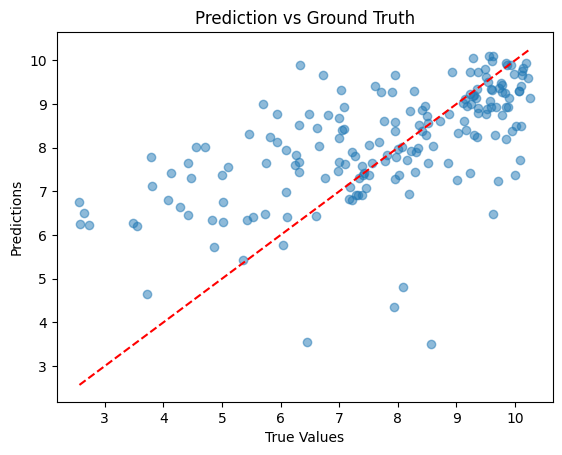

In [235]:

start_time = time.time()     
model.eval()

if classification:

    test_loss_t, test_accuracy_t, test_y_true_t, test_y_pred_t = validate(model, test_loader_t, criterion, device, classification)

    predictions_t = np.array(test_y_pred_t)
    ground_truth_t = np.array(test_y_true_t)
    cm = confusion_matrix(ground_truth_t, predictions_t)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()

    edges = np.array([2.9748, 3.9777, 4.9806, 5.9835, 6.9864, 7.9893, 8.9922, 9.9951])
    tl  = (edges[:-1] + edges[1:]) / 2
 
    mapped_predictions_t = np.array([tl[pred] for pred in predictions_t])
    mapped_ground_truth_t = reg_labels_t.detach().cpu().numpy().copy()
    rmse_t = np.sqrt(np.mean((mapped_predictions_t - mapped_ground_truth_t) ** 2))
    mae_t = np.mean(np.abs(mapped_predictions_t - mapped_ground_truth_t))
    r2_t = r2_score(mapped_ground_truth_t, mapped_predictions_t)
    accuracy = np.mean(np.array(ground_truth_t) == np.array(predictions_t)) * 100

    print(f"Accuracy: {accuracy:.2f}%")
    ground_truth_t = np.array(mapped_ground_truth_t)
    predictions_t = np.array(mapped_predictions_t)

else:

    test_loss_t, ground_truth_t, predictions_t = validate(model, test_loader_t, criterion, device, classification)
    end_time = time.time()  # End timing
    test_time = end_time - start_time

    print(f"Testing time: {test_time:.6f} seconds.")

    predictions_t = np.array(predictions_t)
    ground_truth_t = np.array(ground_truth_t)

    predictions_t = (predictions_t * labels_std_t) + labels_mean_t
    mae_t = np.mean(np.abs(predictions_t - ground_truth_t))
    rmse_t = np.sqrt(np.mean((predictions_t - ground_truth_t) ** 2))
    r2_t = r2_score(ground_truth_t, predictions_t)
    

print(predictions_t[:5])
print(ground_truth_t[:5])


print(f'MAE: {mae_t}, RMSE: {rmse_t}, R2: {r2_t}')

save_dict = {
    "ground_truth": ground_truth_t,
    "predictions": predictions_t
}

savemat('metric_results_r3.mat', save_dict)

plt.figure()
plt.scatter(ground_truth_t, predictions_t, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Prediction vs Ground Truth")
plt.plot([min(ground_truth_t), max(ground_truth_t)], [min(ground_truth_t), max(ground_truth_t)], color='red', linestyle='--')
plt.savefig(f"scatter.png")
plt.show()
plt.close()
